In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sairamrockhy","key":"602dc17619c76d28d2367908344de9f4"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d l33tc0d3r/indian-food-classification

100% 1.48G/1.48G [00:18<00:00, 63.3MB/s]
100% 1.48G/1.48G [00:18<00:00, 84.6MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('indian-food-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
data_dir='/content/Food Classification'
data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 6269 files belonging to 20 classes.


In [ ]:
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.2)

In [ ]:
train_data = datagen.flow_from_directory(
    data_dir,
    target_size = (228,228),
    batch_size =32,
    class_mode = 'categorical',
    subset = 'training')
val_data = datagen.flow_from_directory(
    data_dir,
    target_size = (228,228),
    batch_size =32,
    class_mode='categorical',
    subset = 'validation')

Found 5024 images belonging to 20 classes.
Found 1245 images belonging to 20 classes.


In [ ]:
model=InceptionV3(weights='imagenet',include_top=False,input_shape=(228,228,3),pooling='avg')
for layer in model.layers:
    layer.trainable=False

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

In [ ]:
input=model.output
input=BatchNormalization(axis=-1)(input)
input=Dense(1024,activation='relu')(input)
input=Dropout(0.3)(input)
output = Dense(20, activation='softmax')(input)
m = Model(inputs = model.input, outputs = output)
m.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

In [ ]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 228, 228, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 113, 113, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 113, 113, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 113, 113, 32)         0         ['batch_normalization[0][0

In [ ]:
import matplotlib.pyplot as plt
def show_img(data):
    plt.figure(figsize=(15,15))
    for images,labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

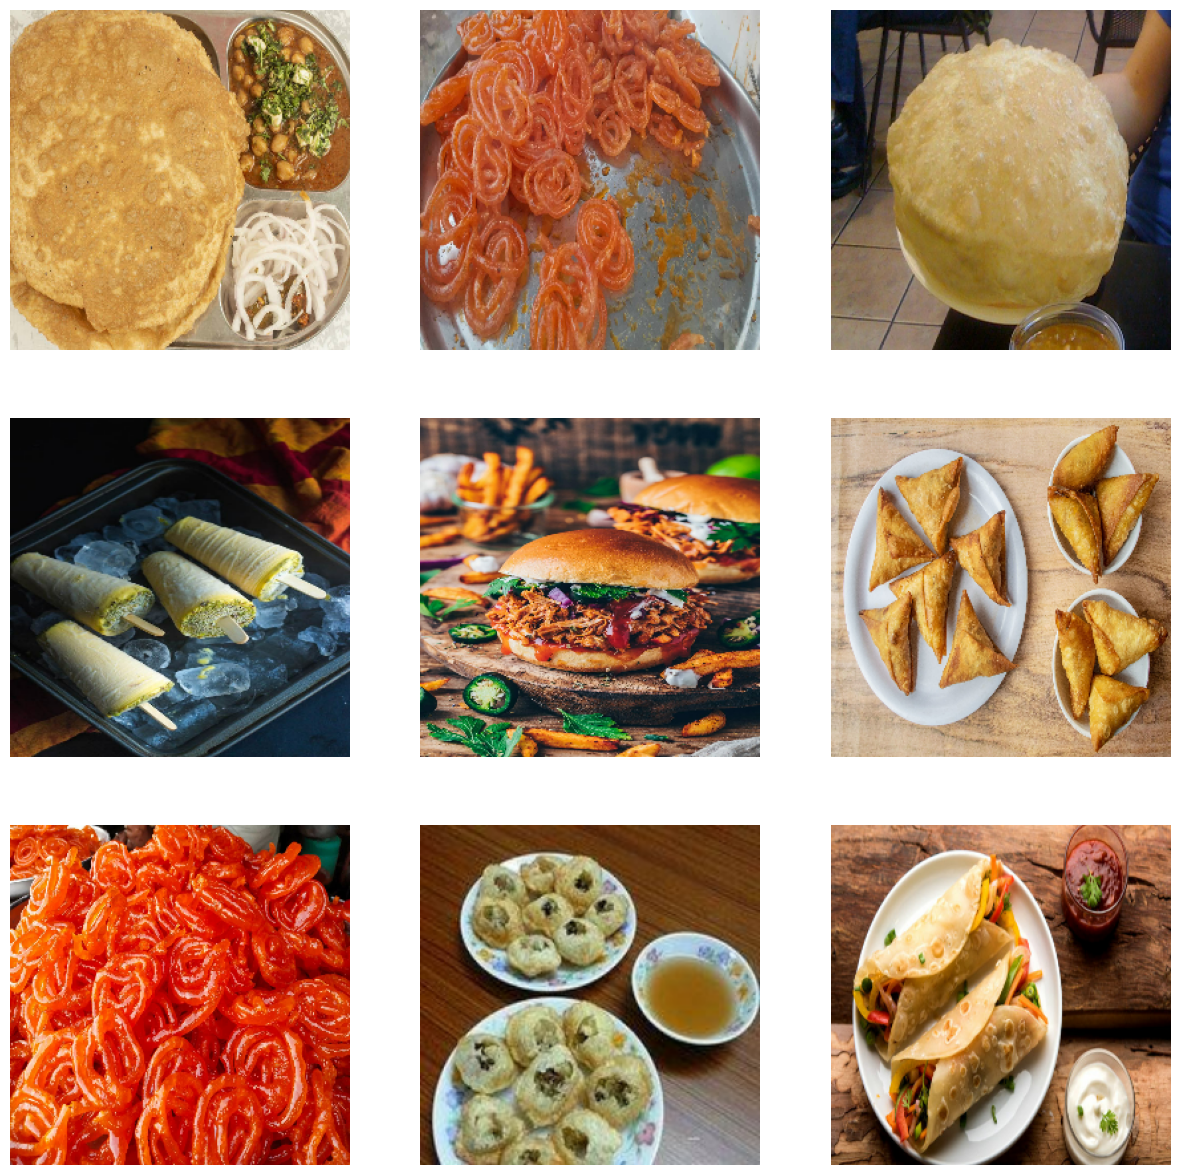

In [ ]:
show_img(data)

In [ ]:
batch_size=32
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size
his=m.fit(train_data,
                    validation_data = val_data,
                    epochs = 5,
                    verbose = 1)

Epoch 1/5
157/157 [==============================] - 944s 6s/step - loss: 1.9530 - accuracy: 0.5635 - val_loss: 0.8335 - val_accuracy: 0.7679
Epoch 2/5
157/157 [==============================] - 882s 6s/step - loss: 1.3191 - accuracy: 0.6867 - val_loss: 0.8260 - val_accuracy: 0.7647
Epoch 3/5
157/157 [==============================] - 903s 6s/step - loss: 1.1641 - accuracy: 0.7008 - val_loss: 0.7723 - val_accuracy: 0.7928
Epoch 4/5
157/157 [==============================] - 872s 6s/step - loss: 0.9903 - accuracy: 0.7452 - val_loss: 0.6784 - val_accuracy: 0.8137
Epoch 5/5
157/157 [==============================] - 907s 6s/step - loss: 0.8468 - accuracy: 0.7661 - val_loss: 0.6418 - val_accuracy: 0.8201


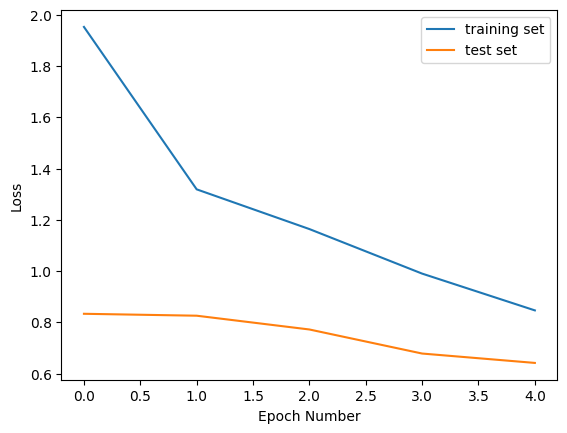

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(his.history['loss'], label='training set')
plt.plot(his.history['val_loss'], label='test set')
plt.legend()

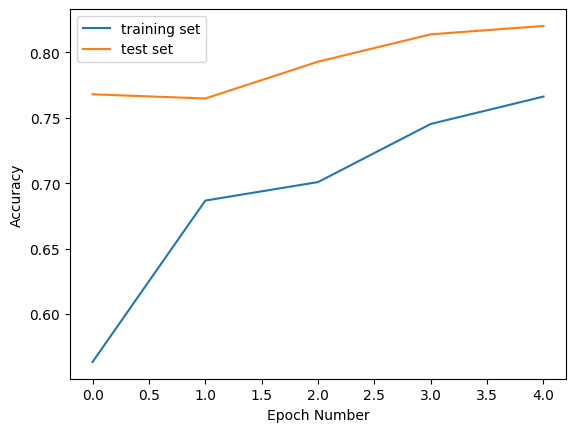

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(his.history['accuracy'], label='training set')
plt.plot(his.history['val_accuracy'], label='test set')
plt.legend()

In [ ]:
results=m.evaluate(train_data)
results

157/157 [==============================] - 721s 5s/step - loss: 0.5048 - accuracy: 0.8477


[0.5048274397850037, 0.8477308750152588]

In [ ]:
model_name ='food_recognition_inceptionV3.h5'
m.save(model_name, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow import keras
model = keras.models.load_model('food_recognition_inceptionV3.h5')

In [ ]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

In [ ]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

In [ ]:
!curl -o burger.png "https://images.unsplash.com/photo-1568901346375-23c9450c58cd?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8YnVyZ2VyfGVufDB8fDB8fA%3D%3D&w=1000&q=80"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  104k  100  104k    0     0   403k      0 --:--:-- --:--:-- --:--:--  403k


In [ ]:
!curl -o samosa.png "https://upload.wikimedia.org/wikipedia/commons/c/cb/Samosachutney.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  134k  100  134k    0     0   389k      0 --:--:-- --:--:-- --:--:--  390k


In [ ]:
!curl -o dhokla.png "https://akm-img-a-in.tosshub.com/aajtak/images/story/202203/maggi_masala_32-sixteen_nine.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67004  100 67004    0     0   191k      0 --:--:-- --:--:-- --:--:--  191k


In [ ]:
!curl -o cb.png "https://en-media.thebetterindia.com/uploads/2022/08/294156779_1082267416022212_8006411537588067133_n-1_11zon-1660981126.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  150k  100  150k    0     0   628k      0 --:--:-- --:--:-- --:--:--  627k


In [ ]:
!curl -o ch.png "https://www.bigbasket.com/media/uploads/recipe/w-l/2662_1_1.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22030  100 22030    0     0  72746      0 --:--:-- --:--:-- --:--:-- 72947


1/1 [==============================] - 0s 269ms/step


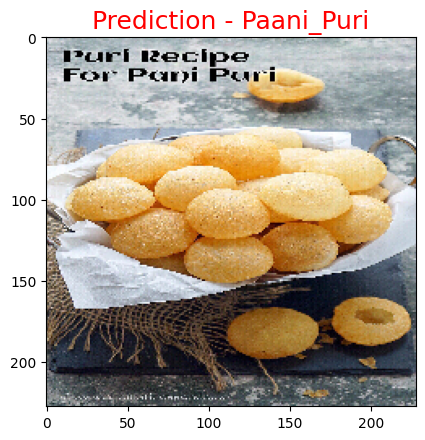

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
predict_image('/content/Food Classification/paani_puri/013.jpg',m)

1/1 [==============================] - 0s 291ms/step


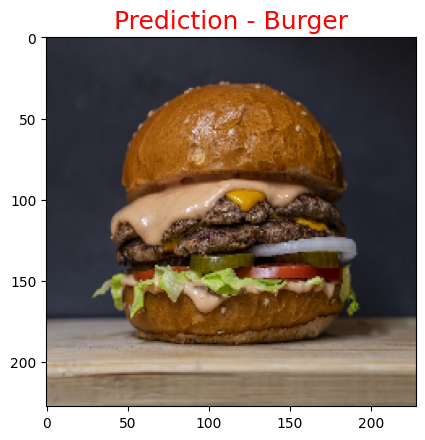

In [ ]:
predict_image('/content/burger.png',m)

1/1 [==============================] - 0s 260ms/step


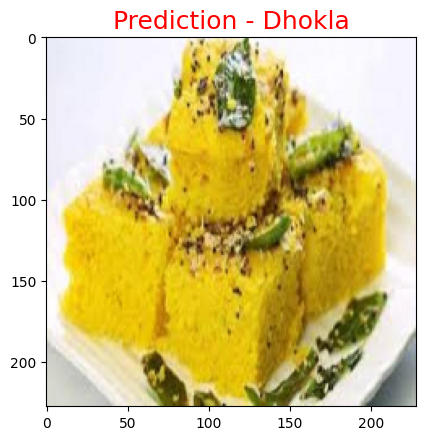

In [ ]:
predict_image('/content/dhokla.png',m)

In [ ]:
print('Accuracy:-',results[1]*100)

Accuracy:- 84.77308750152588
